In [3]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

import matplotlib.cm as cm

from math import *

from mpl_toolkits.mplot3d.axes3d import Axes3D

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns

In [4]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import savitzky_golay as sg
#lib_path = os.path.abspath('/Users/anakarinarm/SubmarineCanyonsResearch/PythonModulesMITgcm') # Add absolute path to my python scripts

#sys.path.append(lib_path)

#import ReadOutTools_MITgcm as rout 


In [5]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [6]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, bathy, sbdepth=-152.5):
    '''Tr: tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)'''
       
      
    Conc = np.empty((19,360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                Conc[tt,i,j] = TrBottom
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    

    #ConcAreaMasked = np.ma.masked_values(ConcDepths,-2.5)
    #ConcDepths[np.where(np.ma.getmask(ConcDepthsMasked)==True)] = np.nan

    return (np.ma.masked_array(Conc, mask=maskShelf),
            np.ma.masked_array(BottomInd, mask=maskShelf[1,:,:]),
            maskShelf)

In [7]:
#Base case, iso =1 , No 3d diff.
#CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

NoCCanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
NoCCanyonGridOut = Dataset(NoCCanyonGrid)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

Ptracer='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'
PtracerOut = Dataset(Ptracer)

PtracerNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/ptracersGlob.nc'
PtracerNoCOut = Dataset(PtracerNoC)


In [54]:
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
bathy = rout.getField(CanyonGrid, 'Depth')
bathyNoC = rout.getField(NoCCanyonGrid, 'Depth')

hFacC = rout.getField(NoCCanyonGrid, 'HFacC')
MaskC = rout.getMask(NoCCanyonGrid, 'HFacC')

z = CanyonStateOut.variables['Z']



In [55]:
Tr1 = rout.getField(Ptracer,'Tr1') # 

In [56]:
Conc1, bottomIndices, maskSh = BottomConc(Tr1, hFacC, bathy)

(360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [57]:
z2D = np.empty(np.shape(xc))
for j in range(360):
     for i in range(360):
        z2D[i,j] = z[int(bottomIndices.data[i,j])]
        

In [58]:
N = np.ma.masked_array(Conc1[10,227:,:]/np.nanmax(Conc1[10,227:,:]),mask=maskSh[0,227:,:])

xx = np.ma.masked_array(xc[:,:],mask=maskSh[0,:,:])
yy = np.ma.masked_array(yc[:,:],mask=maskSh[0,:,:])

zz = np.ma.masked_array(z2D[:,:],mask=maskSh[0,:,:])

zz[np.where(np.ma.getmask(zz)==True)] = np.nan



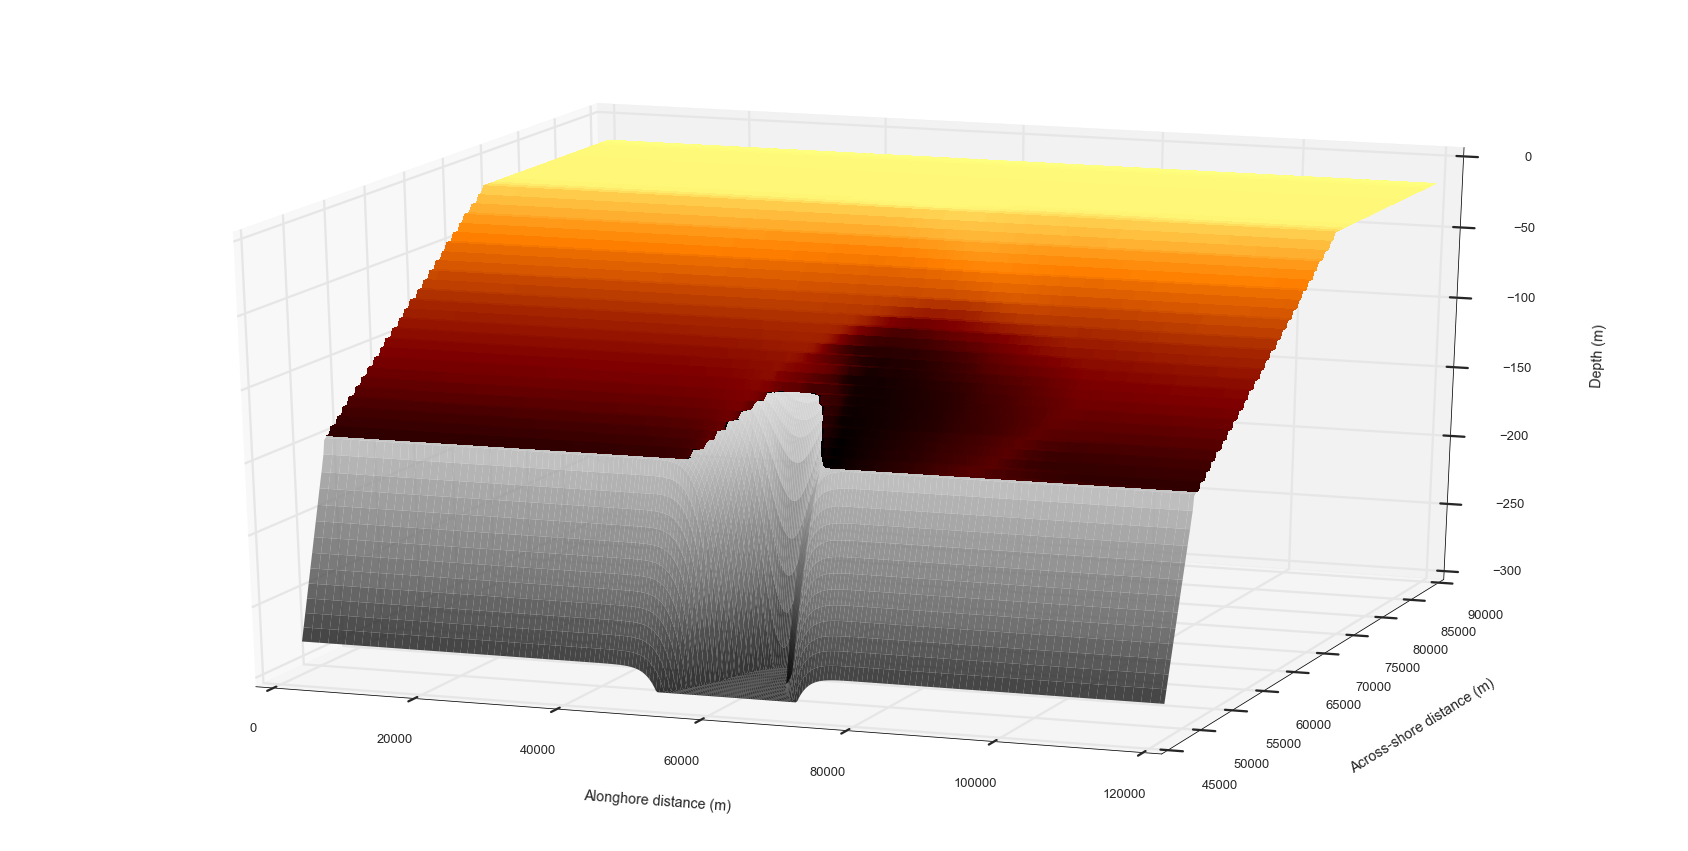

In [74]:
plt.rcParams['contour.negative_linestyle'] = 'solid' # default is to have negative contours with dashed lines
plt.rcParams.update({'font.size':24})

# Plot 3D bathymetry
bathy2 = bathy
bathy2[bathy2 > 300] = 300

fig = plt.figure(figsize=(30,15))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')

ax1.set_zlim3d(-300, 0)

p = ax1.plot_surface(xc[200:-60,:],yc[200:-60,:],-bathy2[200:-60,:],cmap='Greys_r',
                     linewidth=0.0,alpha=0.8,rstride=2,cstride=2,shade=True)



iso = ax1.plot_surface(xx[227:,:],yy[227:,:],zz[227:,:],
                       linewidth=0.0,alpha=1.0,rstride=2,cstride=2,
                       facecolors=cm.afmhot_r(N),#cm.gist_heat_r(N),
                       vmin=np.nanmin(zz), vmax=np.nanmax(zz),
                       antialiased=False, shade=False)


#cset = ax1.contour(xc[200:-60,:],yc[200:-60,:],-bathy2[200:-60,:],[-300,-200,-150,-125,-100,-75,-50],colors='0.50',linewidth=1, rstride=2, cstride=2,zdir='z')
#cset2 = ax1.contour(xc[200:-60,110:250],yc[200:-60,110:250],-bathy2[200:-60,110:250],[rc[30]],colors='r',linewidth=3, rstride=2, cstride=2,zdir='z')



ax1.set_aspect('auto')

ax1.view_init(20, -70) # elevation and azimuth

ax1.set_ylabel('Across-shore distance (m)')
ax1.set_xlabel('Alonghore distance (m)')
ax1.set_zlabel('Depth (m)')


#fig.savefig('/home/kramosmu/Documents/CMOS2016/Figures/BottomConcentration3D.png', format='png', dpi=1000, bbox_inches='tight')
#Takes forever to save the png figure and it is about 7Mb